In [1]:
%matplotlib inline

In [2]:
import os
import pathlib
import sys

In [3]:
base_path = pathlib.Path(os.getcwd())
base_path = str(base_path.parent)
sys.path = [base_path] + sys.path

In [4]:
import random as python_random
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [5]:
import tensorflow as tf
import tensorflow_datasets as tfds
from sklearn import metrics
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras import layers
from tensorflow.keras.utils import model_to_dot
from IPython.display import SVG

In [6]:
sns.set(context="notebook", style="darkgrid", palette="deep", font="sans-serif", font_scale=1.0, color_codes=True)

In [7]:
os.makedirs("./img/", exist_ok=True)
os.makedirs("./score/", exist_ok=True)

In [8]:
seed = 6902

# The below is necessary for starting Numpy generated random numbers
# in a well-defined initial state.
np.random.seed(seed)

# The below is necessary for starting core Python generated random numbers
# in a well-defined state.
python_random.seed(seed)

# The below set_seed() will make random number generation
# in the TensorFlow backend have a well-defined initial state.
# For further details, see:
# https://www.tensorflow.org/api_docs/python/tf/random/set_seed
tf.random.set_seed(seed)

In [9]:
from pynvml import *

try:
    nvmlInit()
    print("Driver Version:", nvmlSystemGetDriverVersion())
    deviceCount = nvmlDeviceGetCount()
    for i in range(deviceCount):
        handle = nvmlDeviceGetHandleByIndex(i)
        print("Device", i, ":", nvmlDeviceGetName(handle))
    nvmlShutdown()
except NVMLError as error:
    print(error)

Driver Version: b'419.17'
Device 0 : b'GeForce GTX 1070 Ti'


In [10]:
from cpuinfo import get_cpu_info

for key, value in get_cpu_info().items():
    print("{0}: {1}".format(key, value))

python_version: 3.6.10.final.0 (64 bit)
cpuinfo_version: [7, 0, 0]
cpuinfo_version_string: 7.0.0
arch: X86_64
bits: 64
count: 12
arch_string_raw: AMD64
vendor_id_raw: GenuineIntel
brand_raw: Intel(R) Core(TM) i7-8700 CPU @ 3.20GHz
hz_advertised_friendly: 3.2000 GHz
hz_actual_friendly: 3.1920 GHz
hz_advertised: [3200000000, 0]
hz_actual: [3192000000, 0]
l2_cache_size: 1572864
stepping: 10
model: 158
family: 6
l3_cache_size: 12582912
flags: ['3dnow', '3dnowprefetch', 'abm', 'acpi', 'adx', 'aes', 'apic', 'avx', 'avx2', 'bmi1', 'bmi2', 'clflush', 'clflushopt', 'cmov', 'cx16', 'cx8', 'de', 'dtes64', 'dts', 'erms', 'est', 'f16c', 'fma', 'fpu', 'fxsr', 'hle', 'ht', 'hypervisor', 'ia64', 'invpcid', 'lahf_lm', 'mca', 'mce', 'mmx', 'movbe', 'mpx', 'msr', 'mtrr', 'osxsave', 'pae', 'pat', 'pbe', 'pcid', 'pclmulqdq', 'pdcm', 'pge', 'pni', 'popcnt', 'pse', 'pse36', 'rdrnd', 'rdseed', 'rtm', 'sep', 'serial', 'smap', 'smep', 'ss', 'sse', 'sse2', 'sse4_1', 'sse4_2', 'ssse3', 'tm', 'tm2', 'tsc', 'vme', 

In [11]:
import psutil 

mem = psutil.virtual_memory() 
print("memory: {0:.2f}GB".format(mem.total / 1024**3))

memory: 15.92GB


In [12]:
BAYES_MODELS = [
    "MNIST-CNN",
]

LAST_ACTIVATIONS = [
    "softmax",
    "sigmoid",
]

PREDICTION_MODES = [
    "Normal-mode",
    "Linear-mode",
    "Independent-mode",
    "Upper-mode",
    "MC-mode",
]

DATASETS = [
    "MNIST",
    "Fashion",
    "Kuzushiji",
    "Kannada",
    "EMNIST-MNIST",
]

In [13]:
class Args(object):
    train_domain = DATASETS[1]
    bayes_model= BAYES_MODELS[0]
    last_activation = LAST_ACTIVATIONS[0]
    num_mc = 100
    optimizer = "Adam"
    train_batch_size = 128
    test_batch_size = 2048
    max_epochs = 100
    patience = 10
    
# class Args(object):
#     train_domain = DATASETS[1]
#     bayes_model= BAYES_MODELS[0]
#     last_activation = LAST_ACTIVATIONS[1]
#     num_mc = 100
#     optimizer = "Adam"
#     train_batch_size = 128
#     test_batch_size = 2048
#     max_epochs = 100
#     patience = 10    

In [14]:
def kuzushiji_load_data():
    ds = tfds.load(
        "kmnist", split=["train", "test"], shuffle_files=False, batch_size=-1
    )
    ds = tfds.as_numpy(ds)
    y_train = ds[0]["label"].astype("uint8")
    x_train = ds[0]["image"].reshape((-1, 28, 28)).astype("uint8")
    y_test = ds[1]["label"].astype("uint8")
    x_test = ds[1]["image"].reshape((-1, 28, 28)).astype("uint8")

    return (x_train, y_train), (x_test, y_test)


def kannada_load_data():
    path = tf.keras.utils.get_file(
        "y_kannada_MNIST_train.npz",
        "https://github.com/vinayprabhu/Kannada_MNIST/raw/master/data/output_tensors/MNIST_format/y_kannada_MNIST_train.npz",
    )
    y_train = np.load(path)["arr_0"]

    path = tf.keras.utils.get_file(
        "X_kannada_MNIST_train.npz",
        "https://github.com/vinayprabhu/Kannada_MNIST/raw/master/data/output_tensors/MNIST_format/X_kannada_MNIST_train.npz",
    )
    x_train = np.load(path)["arr_0"]

    path = tf.keras.utils.get_file(
        "y_kannada_MNIST_test.npz",
        "https://github.com/vinayprabhu/Kannada_MNIST/raw/master/data/output_tensors/MNIST_format/y_kannada_MNIST_test.npz",
    )
    y_test = np.load(path)["arr_0"]

    path = tf.keras.utils.get_file(
        "X_kannada_MNIST_test.npz",
        "https://github.com/vinayprabhu/Kannada_MNIST/raw/master/data/output_tensors/MNIST_format/X_kannada_MNIST_test.npz",
    )
    x_test = np.load(path)["arr_0"]

    return (x_train, y_train), (x_test, y_test)


def emnist_mnist_load_data():
    ds = tfds.load(
        "emnist/mnist", split=["train", "test"], shuffle_files=False, batch_size=-1
    )
    ds = tfds.as_numpy(ds)
    y_train = ds[0]["label"].astype("uint8")
    x_train = ds[0]["image"].reshape((-1, 28, 28)).astype("uint8")
    y_test = ds[1]["label"].astype("uint8")
    x_test = ds[1]["image"].reshape((-1, 28, 28)).astype("uint8")

    x_train = np.array([x.T for x in x_train])
    x_test = np.array([x.T for x in x_test])

    return (x_train, y_train), (x_test, y_test)


def load_dataset(dataset, val_size=1.0 / 6.0):
    if dataset == DATASETS[0]:
        load_data = keras.datasets.mnist.load_data
    elif dataset == DATASETS[1]:
        load_data = keras.datasets.fashion_mnist.load_data
    elif dataset == DATASETS[2]:
        load_data = kuzushiji_load_data
    elif dataset == DATASETS[3]:
        load_data = kannada_load_data
    elif dataset == DATASETS[4]:
        load_data = emnist_mnist_load_data
    else:
        raise ValueError("Error")

    # input image dimensions
    num_classes = 10

    # the data, split between train and test sets
    (x_train, y_train), (x_test, y_test) = load_data()

    # Scale images to the [0, 1] range
    x_train = x_train.astype("float32") / 255.0
    x_test = x_test.astype("float32") / 255.0
    # Make sure images have shape (28, 28, 1)
    x_train = np.expand_dims(x_train, -1)
    x_test = np.expand_dims(x_test, -1)

    if val_size > 0.0:
        x_train, x_val, y_train, y_val = train_test_split(
            x_train, y_train, test_size=val_size, stratify=y_train
        )
    else:
        x_val, y_val = x_train, y_train

    # convert class vectors to binary class matrices
    y_train = keras.utils.to_categorical(y_train, num_classes)
    y_val = keras.utils.to_categorical(y_val, num_classes)
    y_test = keras.utils.to_categorical(y_test, num_classes)

    return (x_train, y_train), (x_val, y_val), (x_test, y_test), num_classes

In [15]:
def calc_softmax_entropy(prob):
    entropy = np.sum(-prob * np.log(np.maximum(prob, 1.0e-5)), axis=-1)
    return entropy


def calc_sigmoid_entropy(prob):
    entropy = np.sum(
        -prob * np.log(np.maximum(prob, 1.0e-5))
        - (1.0 - prob) * np.log(np.maximum(1.0 - prob, 1.0e-5)),
        axis=-1,
    )
    return entropy

In [16]:
def create_last_bayes_model(input_shape, output_shape, last_activation):
    # https://github.com/keras-team/keras/blob/master/examples/mnist_cnn.py
    inputs = keras.Input(input_shape)
    conv1 = layers.Conv2D(32, kernel_size=(3, 3), activation="relu")(inputs)
    conv2 = layers.Conv2D(64, (3, 3), activation="relu")(conv1)
    pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv2)
    drop1 = layers.Dropout(0.25)(pool1)
    flat1 = layers.Flatten()(drop1)
    dense1 = layers.Dense(128, activation="relu")(flat1)
    drop2 = layers.Dropout(0.5)(dense1)
    dense2 = layers.Dense(output_shape, activation=last_activation)(drop2)
    model = keras.Model(inputs=inputs, outputs=dense2)

    return model


def create_bayes_model(bayes_model_name, input_shape, output_shape, last_activation):
    if bayes_model_name == BAYES_MODELS[0]:
        model = create_last_bayes_model(input_shape, output_shape, last_activation)
    else:
        raise ValueError()

    return model

In [17]:
args = Args()

In [18]:
(x_train, y_train), (x_val, y_val), (_, _), num_classes = load_dataset(
    args.train_domain
)

input_shape = x_train.shape[1:]
model = create_bayes_model(
    args.bayes_model, input_shape, num_classes, args.last_activation
)

if args.last_activation == LAST_ACTIVATIONS[0]:
    loss_func = "categorical_crossentropy"
    calc_entropy = calc_softmax_entropy
elif args.last_activation == LAST_ACTIVATIONS[1]:
    loss_func = "binary_crossentropy"
    calc_entropy = calc_sigmoid_entropy
else:
    raise ValueError()

es = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=args.patience,
    verbose=1,
    mode="auto",
    restore_best_weights=True,
)

model.compile(
    loss=loss_func, optimizer=args.optimizer, metrics=["accuracy"],
)

model.fit(
    x_train,
    y_train,
    batch_size=args.train_batch_size,
    epochs=args.max_epochs,
    verbose=1,
    validation_data=(x_val, y_val),
    callbacks=[es],
)

Train on 50000 samples, validate on 10000 samples
Epoch 1/100
50000/50000 [==============================] - 6s 117us/sample - loss: 0.5350 - accuracy: 0.8100 - val_loss: 0.3387 - val_accuracy: 0.8772
Epoch 2/100
50000/50000 [==============================] - 3s 62us/sample - loss: 0.3454 - accuracy: 0.8763 - val_loss: 0.2758 - val_accuracy: 0.8983
Epoch 3/100
50000/50000 [==============================] - 3s 62us/sample - loss: 0.2958 - accuracy: 0.8923 - val_loss: 0.2503 - val_accuracy: 0.9088
Epoch 4/100
50000/50000 [==============================] - 3s 63us/sample - loss: 0.2620 - accuracy: 0.9030 - val_loss: 0.2423 - val_accuracy: 0.9139
Epoch 5/100
50000/50000 [==============================] - 3s 59us/sample - loss: 0.2391 - accuracy: 0.9111 - val_loss: 0.2235 - val_accuracy: 0.9164
Epoch 6/100
50000/50000 [==============================] - 3s 59us/sample - loss: 0.2194 - accuracy: 0.9192 - val_loss: 0.2207 - val_accuracy: 0.9201
Epoch 7/100
50000/50000 [========================

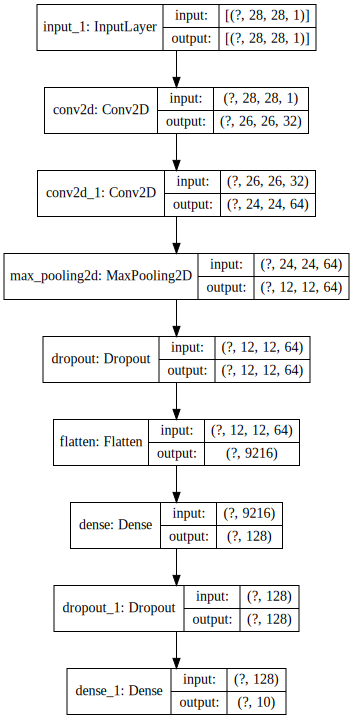

In [19]:
model_to_dot(model, show_shapes=True).write_pdf("img/ood_architecture-nn.pdf")
SVG(model_to_dot(model, show_shapes=True, dpi=72).create(prog='dot', format='svg'))

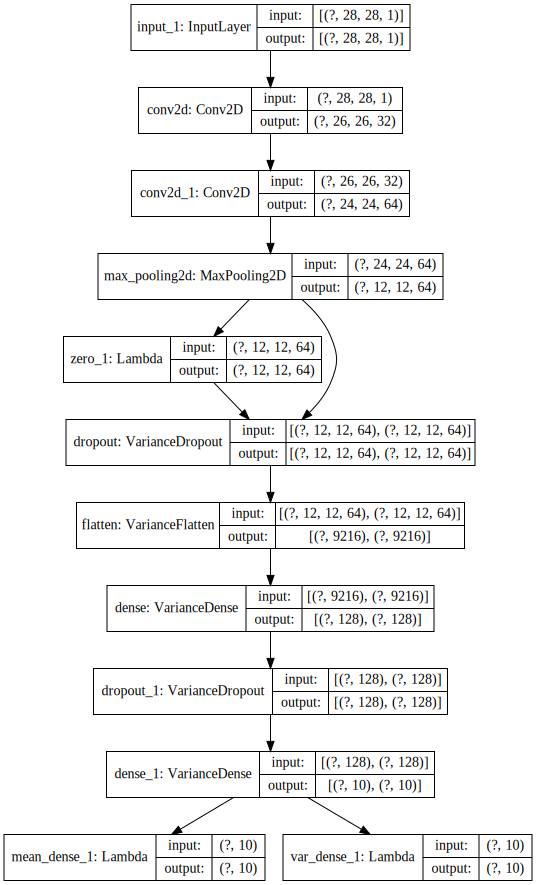

In [20]:
from vpbnn.models import nn2vpbnn
vmodel = nn2vpbnn(model, variance_mode=1)
model_to_dot(vmodel, show_shapes=True).write_pdf("img/ood_architecture-vpbnn.pdf")
SVG(model_to_dot(vmodel, show_shapes=True, dpi=72).create(prog='dot', format='svg'))

In [21]:
from vpbnn import vlayers

score_dfs = []
for prediction_type in PREDICTION_MODES:
    for test_domain in DATASETS:
        (_, _), (_, _), (x_test, y_test), _ = load_dataset(test_domain)
        if prediction_type == PREDICTION_MODES[0]:
            for layer in vmodel.layers:
                if isinstance(layer, vlayers.VarianceLayer):
                    layer.variance_mode = 0
            vmodel.compile(loss=loss_func)

            y_prob, _ = vmodel.predict(x_test, batch_size=args.test_batch_size)
            y_pred = np.argmax(y_prob, axis=-1)
            y_entropy = calc_entropy(y_prob)
            score_df = pd.DataFrame(
                {
                    "prediction_type": "{0}_{1}".format(prediction_type, "entropy"),
                    "train_domain": args.train_domain,
                    "test_domain": test_domain,
                    "y_index": np.arange(x_test.shape[0]),
                    "y_test": np.argmax(y_test, axis=-1),
                    "y_pred": y_pred,
                    "y_prob": np.max(y_prob, axis=-1),
                    "y_uncertainty": y_entropy,
                }
            )
            score_dfs.append(score_df)
        elif prediction_type == PREDICTION_MODES[1]:
            for layer in vmodel.layers:
                if isinstance(layer, vlayers.VarianceLayer):
                    layer.variance_mode = 1
            vmodel.compile(loss=loss_func)

            y_prob, y_var = vmodel.predict(x_test, batch_size=args.test_batch_size)
            y_pred = np.argmax(y_prob, axis=-1)
            y_entropy = calc_entropy(y_prob)
            y_mean_std = np.mean(np.sqrt(y_var), axis=-1)
            score_df = pd.DataFrame(
                {
                    "prediction_type": "{0}_{1}".format(prediction_type, "entropy"),
                    "train_domain": args.train_domain,
                    "test_domain": test_domain,
                    "y_index": np.arange(x_test.shape[0]),
                    "y_test": np.argmax(y_test, axis=-1),
                    "y_pred": y_pred,
                    "y_prob": np.max(y_prob, axis=-1),
                    "y_uncertainty": y_entropy,
                }
            )
            score_dfs.append(score_df)
            score_df = pd.DataFrame(
                {
                    "prediction_type": "{0}_{1}".format(
                        prediction_type, "mean-std"
                    ),
                    "train_domain": args.train_domain,
                    "test_domain": test_domain,
                    "y_index": np.arange(x_test.shape[0]),
                    "y_test": np.argmax(y_test, axis=-1),
                    "y_pred": y_pred,
                    "y_prob": np.max(y_prob, axis=-1),
                    "y_uncertainty": y_mean_std,
                }
            )
            score_dfs.append(score_df)
        elif prediction_type == PREDICTION_MODES[2]:
            for layer in vmodel.layers:
                if isinstance(layer, vlayers.VarianceLayer):
                    layer.variance_mode = 2
            vmodel.compile(loss=loss_func)

            y_prob, y_var = vmodel.predict(x_test, batch_size=args.test_batch_size)
            y_pred = np.argmax(y_prob, axis=-1)
            y_entropy = calc_entropy(y_prob)
            y_mean_std = np.mean(np.sqrt(y_var), axis=-1)
            score_df = pd.DataFrame(
                {
                    "prediction_type": "{0}_{1}".format(prediction_type, "entropy"),
                    "train_domain": args.train_domain,
                    "test_domain": test_domain,
                    "y_index": np.arange(x_test.shape[0]),
                    "y_test": np.argmax(y_test, axis=-1),
                    "y_pred": y_pred,
                    "y_prob": np.max(y_prob, axis=-1),
                    "y_uncertainty": y_entropy,
                }
            )
            score_dfs.append(score_df)
            score_df = pd.DataFrame(
                {
                    "prediction_type": "{0}_{1}".format(
                        prediction_type, "mean-std"
                    ),
                    "train_domain": args.train_domain,
                    "test_domain": test_domain,
                    "y_index": np.arange(x_test.shape[0]),
                    "y_test": np.argmax(y_test, axis=-1),
                    "y_pred": y_pred,
                    "y_prob": np.max(y_prob, axis=-1),
                    "y_uncertainty": y_mean_std,
                }
            )
            score_dfs.append(score_df)
        elif prediction_type == PREDICTION_MODES[3]:
            for layer in vmodel.layers:
                if isinstance(layer, vlayers.VarianceLayer):
                    layer.variance_mode = 3
            vmodel.compile(loss=loss_func)

            y_prob, y_var = vmodel.predict(x_test, batch_size=args.test_batch_size)
            y_pred = np.argmax(y_prob, axis=-1)
            y_entropy = calc_entropy(y_prob)
            y_mean_std = np.mean(np.sqrt(y_var), axis=-1)
            score_df = pd.DataFrame(
                {
                    "prediction_type": "{0}_{1}".format(prediction_type, "entropy"),
                    "train_domain": args.train_domain,
                    "test_domain": test_domain,
                    "y_index": np.arange(x_test.shape[0]),
                    "y_test": np.argmax(y_test, axis=-1),
                    "y_pred": y_pred,
                    "y_prob": np.max(y_prob, axis=-1),
                    "y_uncertainty": y_entropy,
                }
            )
            score_dfs.append(score_df)
            score_df = pd.DataFrame(
                {
                    "prediction_type": "{0}_{1}".format(
                        prediction_type, "mean-std"
                    ),
                    "train_domain": args.train_domain,
                    "test_domain": test_domain,
                    "y_index": np.arange(x_test.shape[0]),
                    "y_test": np.argmax(y_test, axis=-1),
                    "y_pred": y_pred,
                    "y_prob": np.max(y_prob, axis=-1),
                    "y_uncertainty": y_mean_std,
                }
            )
            score_dfs.append(score_df)            
        elif prediction_type == PREDICTION_MODES[4]:
            for layer in vmodel.layers:
                if isinstance(layer, vlayers.VarianceLayer):
                    layer.variance_mode = 4
            vmodel.compile(loss=loss_func)

            y_probs = []
            for _ in range(args.num_mc):
                for layer in model.layers:
                    if isinstance(layer, vlayers.VarianceDropout):
                        layer.update_dropout_mask()
                y_prob, _ = vmodel.predict(x_test, batch_size=args.test_batch_size)
                y_probs.append(y_prob)
            y_probs = np.array(y_probs)
            y_prob = y_probs.mean(axis=0)
            y_pred = np.argmax(y_prob, axis=-1)
            y_entropy = calc_entropy(y_prob)
            y_mean_std = np.mean(y_probs.std(axis=0, ddof=1), axis=-1)
            score_df = pd.DataFrame(
                {
                    "prediction_type": "{0}_{1}".format(prediction_type, "entropy"),
                    "train_domain": args.train_domain,
                    "test_domain": test_domain,
                    "y_index": np.arange(x_test.shape[0]),
                    "y_test": np.argmax(y_test, axis=-1),
                    "y_pred": y_pred,
                    "y_prob": np.max(y_prob, axis=-1),
                    "y_uncertainty": y_entropy,
                }
            )
            score_dfs.append(score_df)
            score_df = pd.DataFrame(
                {
                    "prediction_type": "{0}_{1}".format(
                        prediction_type, "mean-std"
                    ),
                    "train_domain": args.train_domain,
                    "test_domain": test_domain,
                    "y_index": np.arange(x_test.shape[0]),
                    "y_test": np.argmax(y_test, axis=-1),
                    "y_pred": y_pred,
                    "y_prob": np.max(y_prob, axis=-1),
                    "y_uncertainty": y_mean_std,
                }
            )
            score_dfs.append(score_df)
        else:
            raise ValueError()
score_df = pd.concat(score_dfs, ignore_index=True)
score_df["seed"] = seed
score_df["bayes_model"] = args.bayes_model
score_df["last_activation"] = args.last_activation

In [22]:
def calc_auc(df, train_domain, test_domain):
    auc_dfs = []
    for pred_type in df['prediction_type'].unique():
        for bayes_model in df['bayes_model'].unique():
            for activation in df['last_activation'].unique():            
                cond_df = df[df['prediction_type'] == pred_type]
                cond_df = cond_df[cond_df['bayes_model'] == bayes_model]
                cond_df = cond_df[cond_df['last_activation'] == activation]
                fpr, tpr, thresholds = metrics.roc_curve(cond_df['test_domain'], -cond_df['y_uncertainty'], pos_label=train_domain)
                roc_auc = metrics.auc(fpr, tpr)
                auc_df = pd.DataFrame({'train_domain': [train_domain], 'test_domain': [test_domain], 'prediction_type': [pred_type], 'bayes_model': [bayes_model], 'last_activation': [activation], 'auc': [roc_auc]})
                auc_dfs.append(auc_df)
        
    auc_df = pd.concat(auc_dfs, ignore_index=True)
    auc_df['seed'] = df['seed'].iloc[0]
        
    return auc_df

In [23]:
auc_dfs = []
for train_domain in score_df['train_domain'].unique():
    other_domains = set(score_df['test_domain'].unique()) - set([train_domain])
    for other_domain in other_domains:
        cond = np.logical_and(score_df['train_domain'] == train_domain, np.logical_or(score_df['test_domain'] == train_domain, score_df['test_domain'] == other_domain))
        auc_df = calc_auc(score_df[cond], train_domain, other_domain)
        auc_dfs.append(auc_df)
auc_df = pd.concat(auc_dfs, ignore_index=True)

In [24]:
auc_df.groupby(['train_domain', 'test_domain', 'prediction_type', 'bayes_model', 'last_activation']).agg({'auc': ['mean', 'std']})

auc  \
                                                                                     mean   
train_domain test_domain  prediction_type           bayes_model last_activation             
Fashion      EMNIST-MNIST Independent-mode_entropy  MNIST-CNN   softmax          0.883108   
                          Independent-mode_mean-std MNIST-CNN   softmax          0.917238   
                          Linear-mode_entropy       MNIST-CNN   softmax          0.764840   
                          Linear-mode_mean-std      MNIST-CNN   softmax          0.749324   
                          MC-mode_entropy           MNIST-CNN   softmax          0.869280   
                          MC-mode_mean-std          MNIST-CNN   softmax          0.918500   
                          Normal-mode_entropy       MNIST-CNN   softmax          0.764840   
                          Upper-mode_entropy        MNIST-CNN   softmax          0.765313   
                          Upper-mode_mean-std       MNIST-CNN   softmax          0.807105   
             Kannada      Independent-mode_entropy  MNIST-CNN   softmax          0.871678   
                          Independent-mode_mean-std MNIST-CNN   softmax          0.914398   
                          Linear-mode_entropy       MNIST-CNN   softmax          0.709041   
                          Linear-mode_mean-std      MNIST-CNN   softmax          0.725609   
                          MC-mode_entropy           MNIST-CNN   softmax          0.854616   
                          MC-mode_mean-std          MNIST-CNN   softmax          0.921799   
                          Normal-mode_entropy       MNIST-CNN   softmax          0.709041   
                          Upper-mode_entropy        MNIST-CNN   softmax          0.765758   
                          Upper-mode_mean-std       MNIST-CNN   softmax          0.850439   
             Kuzushiji    Independent-mode_entropy  MNIST-CNN   softmax          0.934244   
                          Independent-mode_mean-std MNIST-CNN   softmax          0.960795   
                          Linear-mode_entropy       MNIST-CNN   softmax          0.819462   
                          Linear-mode_mean-std      MNIST-CNN   softmax          0.828641   
                          MC-mode_entropy           MNIST-CNN   softmax          0.918932   
                          MC-mode_mean-std          MNIST-CNN   softmax          0.964153   
                          Normal-mode_entropy       MNIST-CNN   softmax          0.819462   
                          Upper-mode_entropy        MNIST-CNN   softmax          0.701608   
                          Upper-mode_mean-std       MNIST-CNN   softmax          0.804766   
             MNIST        Independent-mode_entropy  MNIST-CNN   softmax          0.838216   
                          Independent-mode_mean-std MNIST-CNN   softmax          0.890108   
                          Linear-mode_entropy       MNIST-CNN   softmax          0.662541   
                          Linear-mode_mean-std      MNIST-CNN   softmax          0.675268   
                          MC-mode_entropy           MNIST-CNN   softmax          0.816835   
                          MC-mode_mean-std          MNIST-CNN   softmax          0.891181   
                          Normal-mode_entropy       MNIST-CNN   softmax          0.662541   
                          Upper-mode_entropy        MNIST-CNN   softmax          0.799200   
                          Upper-mode_mean-std       MNIST-CNN   softmax          0.829391   

                                                                                     
                                                                                std  
train_domain test_domain  prediction_type           bayes_model last_activation      
Fashion      EMNIST-MNIST Independent-mode_entropy  MNIST-CNN   softmax         NaN  
                          Independent-mode_mean-std MNIST-CNN   softmax         NaN  
                          Li

In [25]:
df = score_df[score_df['train_domain'] == score_df['test_domain']]
df = df.reset_index(drop=True)
df['correct'] = df['y_test'] == df['y_pred']
accuracy_df = df[['train_domain', 'prediction_type', 'bayes_model', 'last_activation', 'correct']].groupby(['train_domain', 'prediction_type', 'bayes_model', 'last_activation']).mean().reset_index()
accuracy_df = accuracy_df.rename(columns={'correct': 'accuracy'})
accuracy_df['seed'] = df['seed'].iloc[0]

In [26]:
accuracy_df.groupby(['train_domain', 'prediction_type', 'bayes_model', 'last_activation']).agg({'accuracy': ['mean', 'std']})

accuracy  \
                                                                       mean   
train_domain prediction_type           bayes_model last_activation            
Fashion      Independent-mode_entropy  MNIST-CNN   softmax           0.9212   
             Independent-mode_mean-std MNIST-CNN   softmax           0.9212   
             Linear-mode_entropy       MNIST-CNN   softmax           0.9221   
             Linear-mode_mean-std      MNIST-CNN   softmax           0.9221   
             MC-mode_entropy           MNIST-CNN   softmax           0.9203   
             MC-mode_mean-std          MNIST-CNN   softmax           0.9203   
             Normal-mode_entropy       MNIST-CNN   softmax           0.9221   
             Upper-mode_entropy        MNIST-CNN   softmax           0.7757   
             Upper-mode_mean-std       MNIST-CNN   softmax           0.7757   

                                                                        
                                                                   std  
train_domain prediction_type           bayes_model last_activation      
Fashion      Independent-mode_entropy  MNIST-CNN   softmax         NaN  
             Independent-mode_mean-std MNIST-CNN   softmax         NaN  
             Linear-mode_entropy       MNIST-CNN   softmax         NaN  
             Linear-mode_mean-std      MNIST-CNN   softmax         NaN  
             MC-mode_entropy           MNIST-CNN   softmax         NaN  
             MC-mode_mean-std          MNIST-CNN   softmax         NaN  
             Normal-mode_entropy       MNIST-CNN   softmax         NaN  
             Upper-mode_entropy        MNIST-CNN   softmax         NaN  
             Upper-mode_mean-std       MNIST-CNN   softmax         NaN